## EECS 491 Assignment 3

  Yue Shu  
  Spring 2019  
  Prof. Lewicki  
  

**IMPORTANT: all image results I had for my last update are stored under the folder `Images`, and all images I load in the Jupyter Notebook are also under that image direcotry. However, images generated by the code will be directly restored in the `Outputs` folder, where I left no image right now just for you to initialize.**

# Exercise 1. MRFs and Images Denoising

In this problem, you will implement the image de-noising example using a Markov Random Field (MRF).  This material on MRFs is covered in the textbook (Barber) in chapter 4.2.5. The lecture and this problem is based on the presentation in Bishop in chapter 8.3, which is available online.

As discussed in class, energy function for this MRF is

$$ E(\mathbf{x}, \mathbf{y}) = h \sum_i x_i - \beta \sum_{i,j} x_i x_j - \eta \sum_i x_i y_i $$

where the binary variables $x_i$ represent the unknown, noise-free image pixels, which are binary, i.e. black or white.  The variables $y_i$ represent the observed noisy pixels, i.e. the pixel could randomly change from black ($=-1$) to white ($=+1$) or vice-versa.  

The corresponding joint probability distribution over the variables is

$$ p(\mathbf{x},\mathbf{y}) = \frac{1}{Z} \exp \left[ -E(\mathbf{x},\mathbf{y}) \right] $$

## 1.1 Derive the equation that specifies the change in the energy equation when one variable changes state.

Started with the original energy function equation $E$, we have: 

$$ E(\mathbf{x}, \mathbf{y}) = h \sum_i x_i - \beta \sum_{i,j} x_i x_j - \eta \sum_i x_i y_i $$

  Now let $x_k'$ denote the state of $x_k$ after changing, and $E'$ denotes the new energy equation.
  Since each pixel of the image we're discussing here is a binary variable, we may simply assume that the change of one variable is either from $+1$ to $-1$ or vice-versa. By flipping the state of $x_i$, we simply flip by sign and thus obtain $x_i' = -x_i$.

  Therefore, to calculate the difference in the energy equation, we simply substract $E$ from $E'$ as below:

  $$ E' - E =    E(\mathbf{x}', \mathbf{y}) -   E(\mathbf{x}, \mathbf{y}) $$ 
  $$ =  h * (x_0 + ... + x_k' + ... + x_n) - \beta * (x_0x_1 + ... + x_0x_k' + ... + x_0x_n + ... + x_k'x_0 + ... + x_k'x_n + ... $$
  $$ + x_nx_0 + ... + x_nx_k' + ... + x_nx_{n-1}) - \eta * (x_0y_0 + ... + x_k'y_k + ... + x_ny_n) $$
  $$ - (h * (x_0 + ... + x_k + ... + x_n) - \beta * (x_0x_1 + ... + x_0x_k + ... + x_0x_n + ... + x_kx_0 + ... + x_kx_n + ... $$
  $$ + x_nx_0 + ... + x_nx_k + ... + x_nx_{n-1}) - \eta * (x_0y_0 + ... + x_ky_k + ... + x_ny_n)) $$
  $$ = h * (x_0 + ... - x_k + ... + x_n) - \beta * (x_0x_1 + ... - x_0x_k + ... + x_0x_n + ... - x_kx_0 + ... - x_kx_n + ... $$
  $$ + x_nx_0 + ... - x_nx_k + ... + x_nx_{n-1}) - \eta * (x_0y_0 + ... - x_ky_k + ... + x_ny_n) $$
  $$ - (h * (x_0 + ... + x_k + ... + x_n) - \beta * (x_0x_1 + ... + x_0x_k + ... + x_0x_n + ... + x_kx_0 + ... + x_kx_n + ... $$
  $$ + x_nx_0 + ... + x_nx_k + ... + x_nx_{n-1}) - \eta * (x_0y_0 + ... + x_ky_k + ... + x_ny_n)) $$
  $$ E' - E = -2hx_k + 2\beta (2 \sum_{j \in nbr(k)} x_j x_k) + 2 \eta x_k y_k = -2hx_k + 4\beta \sum_{j \in nbr(k)} x_j x_k + 2 \eta x_k y_k
  $$

And the final equation $E' - E$ that specifies the change in the energy equation when one variable $x_k$ changes state is:

$$ E' - E = -2hx_k + 4\beta \sum_{j \in nbr(k)} x_j x_k + 2 \eta x_k y_k $$

## 1.2  Write a program to iteratively (or in random order) update the state variables to minimize the energy (maximize the probability).  Explain your code.  Show that the update algorithm minimizes the energy $E(\mathbf{x}, \mathbf{y})$.

First of all let's define the function to calculate the energy difference. For future convenience, I make the output of the function an array that can also tell me the index `k` of the pixel under changing. 

  `pixels`: an array indicating the pixel of our image  
  `nbr`: an array indicating $x_j$  
  `k`: the index of $x_k$  
  `yk`: the original observation of $x_k$  
  `h`, `beta`, `eta`: the parameters  

In [1]:
## import all packages used in this assignment

import math
import random
from PIL import Image
from numpy import *
import numpy as np
import graphviz 
from graphviz import Graph

In [2]:
def energy_diff (pixels, nbr, k, yk, h, beta, eta):
    output = [0, k]
    sum_xjxk = 0
    i = 0
    ## calculating the sum of all xjxk
    for xj in nbr:
        sum_xjxk += xj * pixels[k]
        i+= 1
    output[0] += - 2 * h * pixels[k] + 4 * beta * sum_xjxk + 2 * eta * pixels[k] * yk
    return output

We also need a helper method to retrieve the neighbours of the pixel we are trying to flip. To eliminate unnecessary edge cases, we may just assume the smallest size of the image is 3x3.

  `width`: the width of the input image  
  `height`: the height of the input image  

In [3]:
def get_nbr (pixels, k, width, height):
    ## the height of k in 2D matrix
    i = int(k / width)
    ## the width of k in 2D matrix
    j = int(k % width)
    ## corners
    if i == 0 and j == 0:
        return [pixels[k + 1], pixels[width]]
    elif i == 0 and j == width - 1:
        return [pixels[k - 1], pixels[k + width]]
    elif i == height - 1 and j == 0:
        return [pixels[k + 1], pixels[k - width]]
    elif i == height - 1 and j == width - 1:
        return [pixels[k - 1], pixels[k - width]]
    ## edges
    elif i == 0:
        return [pixels[k + width], pixels[k + 1], pixels[k - 1]]
    elif i == height - 1:
        return [pixels[k - width], pixels[k + 1], pixels[k - 1]]
    elif j == 0:
        return [pixels[k + 1], pixels[k + width], pixels[k - width]]
    elif j == width - 1:
        return [pixels[k - 1], pixels[k + width], pixels[k - width]]
    # body
    else:
        return [pixels[k + 1], pixels[k - 1], pixels[k + width], pixels[k - width]]

Now we can go ahead and setup our algorithm. 

  I'll implement with a simplified version of simulated annealing algorithm we covered in EECS391, with our energy difference function as the heuristic.   
  So when the energy difference is negative, which means the energy is decreasing, we just accept the result and keep descenting; when the energy difference is positive, we accept the result with a probability less than 1.  

In [4]:
## a helper to determine the probability of acceptance
def accept (delta, T):
    ## catch overflow error
    try:
        return math.exp( - delta / T)
    except OverflowError:
        return 0

## simulated annealing algorithm
def anneal(pix, dim, param_anneal, param_energy):
    
    ## setting up the parameters
    T = param_anneal[0]
    T_min = param_anneal[1]
    alpha = param_anneal[2]
    
    h = param_energy[0]
    beta = param_energy[1]
    eta = param_energy[2]
    
    width = dim[0]
    height = dim[1]
    
    ## the result we want
    output = pix[:]
    
    ## continue annealing as long as the temperature is higher than the terminate value
    while T > T_min:
        for i in range(50):
            ## randomly pick an index k from the pixels
            k = random.randint(0, len(output) - 1)
            ## retrieve the neighbours of k
            nbr = get_nbr(output, k, width, height)
            diff = energy_diff(output, nbr, k, pix[k], h, beta, eta)
            if diff[0] < 0:
                output[k] = 0 - output[k]
            else:
                ap = accept(diff[0], T)
                if ap > random.random():
                    output[k] = 0 - output[k]
        T = T * alpha
    return output

Finally let's have a wrapper method to also compute the finalized energy $E(\mathbf{x}, \mathbf{y})$:

In [5]:
def __MRF_denoise__ (pixels, dim, param_anneal, param_energy):
    
    pix = pixels[:]
    ## take the output of simulated annealing
    output = anneal(pix, dim, param_anneal, param_energy)
    
    ## setup parameters
    h = param_energy[0]
    beta = param_energy[1]
    eta = param_energy[2]
    
    width = dim[0]
    height = dim[1]
    
    ## the sum variables we need for computing the energy equation
    sum_xi = 0
    sum_xixj = 0
    sum_xiyi = 0
    
    ## compute sum of xi
    for xi in output:
        sum_xi += xi
    
    ## compute sum of xiyi
    i = 0
    for xi in output:
        sum_xiyi += xi * (pixels[i])
        i += 1
    
    ## compute sum of xixj
    i = 0
    for xi in output: 
        for xj in get_nbr(output, i, width, height):
            sum_xixj += xi * xj
        i += 1
    
    return h * sum_xi - beta * sum_xixj - eta * sum_xiyi

  According to simulated annealing algorithm, if given appropriate heuristic, the final energy we get should always end at the global optimal, aka the min energy.  
  However, there does exist some uncertainty in real life practice, where there is no guarantee to always get the most optimal answer. We can first have a really simple example to test our output:

In [6]:
param_anneal = [1, 0.001, 0.999]
param_energy = [0, 1, 2.1]
## assuming the noise is around 10%, and this is supposed to be a very simplified 3x3 all-black image 
pix = [-1,-1,-1,1,-1,-1,-1,-1,-1]
anneal(pix, [3, 3], param_anneal, param_energy)

[-1, -1, -1, -1, -1, -1, -1, -1, -1]

In [7]:
__MRF_denoise__(pix, [3,3], param_anneal, param_energy)

-38.7

  According to the output above, we can see that the final output in this case is just the local minimum.  
  Feel free to try the output, it should return the same results each time. We can practice on some more complexed images in the next part.  

## 1.3 Illustrate the model by plot of the image as it is being de-noised at the beginning, middle, and end of the updating.  Choose images that aren't too high resolution so that the individual pixels are visible as squaures.  You may also do a live plot in a notebook to show it updating continuously, but make sure you have the static plots too in case the dynamic plot has portability issues.

To demonstrate this part, I will be using the a txt file `pepe.txt` as the input pixels. The image was found online and converted to binary pixels via https://www.dcode.fr/binary-image. The original text file has all `black` pixels as `0` and `white` pixels `1`. We may change that to what we need later on. 

Let's start with importing the pixel and inspect the original good pepe image:

In [8]:
## import the primitive pixel file as a whole string to obtain length
with open("pepe.txt") as t:
    text = t.read()
    
## the dimensions of the image
width = 0
height = 0
pixels = []

## import the pixel as 1D array
with open("pepe.txt") as txt:
    for char in range(len(text)):
        letter = txt.read(1)
        if letter.isdigit():
            pixels.append(int(letter))
        elif letter == '\n':
            height += 1

pixels = array(pixels)
width = int(len(pixels) / height)

## create image with Pillow
img = Image.new('1', (width, height))
pixel = img.load()

## pass pixels in the 1D array over the pixel of the image
index = 0
for i in range(height):
    for j in range(width):
        pixel[j, i] = int(pixels[index])
        index += 1
        
img.save('Outputs/goodpepe.png')

![original pepe image](Images/goodpepe.png)
Alright, now we have our original good pepe. The next step is to read from the image and do the denoising. We want to arbitrarily flip some bits to make sure we have the "noises" in the image. Suppose we are having a noise rate of at most 10% of total pixels!

In [9]:
## Our good pepe
pic = Image.open('Outputs/goodpepe.png')
## make sure this is a binary image
print(pic.mode)
pix = pic.load()

## the observed pixel array with noises
observe = []
## total number of noises allowed, in this case is 0.1 * total pixels 
max_noises = int(0.1 * len(pixels))
## index of noise pixels
noise = []

## first append the pixels as usual
index = 0
for i in range(height):
    for j in range(width):
        ## to make sure we have +1 for whites and -1 for blacks
        observe.append(int(pix[j, i] / 255) * 2 - 1)
        
## we allow repeated indices in this case, since the noise won't always be exactly 10% in real life
for i in range(max_noises):
    noise.append(random.randint(0, len(pixels) - 1))
      
## flip the bits!
for pix in noise:
    observe[pix] = 0 - observe[pix]
    
observe = array(observe)

1


Now let's take a look the image with noises:

In [10]:
## create image with Pillow
badimg = Image.new('1', (width, height))
badpixel = badimg.load()

## pass pixels in the 1D array over the pixel of the image
index = 0
for i in range(height):
    for j in range(width):
        badpixel[j, i] = int(observe[index])
        index += 1
        
badimg.save('Outputs/badpepe.png')

![noisy pepe image](Images/badpepe.png)

Awesome, we have the ugly pepe as expected. Don't feel bad about pepe, let's take a look at how our MRF denoising algorithm can change the situation.

To make sure we can also see the image in the middle of the updating, let's first make a few modification on our MRF method from the previous part. What we will do is to break the simulated annealing to two steps, from the original temperature to the half, take a look at the result, and then continue to go from the half to the min temperature. 

In [11]:
def show_denoise (pixels, dim, param_anneal, param_energy, imgname):
    
    pixels = pixels[:]
    
    width = dim[0]
    height = dim[1]
    
    output = anneal(pixels, dim, param_anneal, param_energy)
    
    ## create image with Pillow
    betterimg = Image.new('1', (width, height))
    betterpixel = betterimg.load()

    ## pass pixels in the 1D array over the pixel of the image
    index = 0
    for i in range(height):
        for j in range(width):
            betterpixel[j, i] = int(output[index])
            index += 1
        
    betterimg.save(imgname)
    
    ## setup parameters
    h = param_energy[0]
    beta = param_energy[1]
    eta = param_energy[2]

    ## the sum variables we need for computing the energy equation
    sum_xi = 0
    sum_xixj = 0
    sum_xiyi = 0
    
    ## compute sum of xi
    for xi in output:
        sum_xi += xi
    
    ## compute sum of xiyi
    i = 0
    for xi in output:
        sum_xiyi += xi * (pixels[i])
        i += 1
    
    ## compute sum of xixj
    i = 0
    for xi in output: 
        for xj in get_nbr(output, i, width, height):
            sum_xixj += xi * xj
        i += 1
    
    ## compute the energy function
    result =  h * sum_xi - beta * sum_xixj - eta * sum_xiyi
    print('The final energy is: ') 
    print(result)
    return output

In [12]:
dimpepe = [width, height]
param_anneal = [1, 0.001, 0.999]

In [13]:
param_first = [1, (1 + 0.01) / 2, 0.99]
param_energy = [0, 1, 2.1]
## Half of the updating
betterpixel = show_denoise(observe, dimpepe, param_first, param_energy, 'Outputs/betterpepe.png')

The final energy is: 
-29220.0


Let's take a look at our pepe half way through the updating:
![better pepe image](Images/betterpepe.png)

At least it looks better isn't it

In [14]:
param_second = [(1 + 0.01) / 2, 0.01, 0.99]
## Updating completely done
newpixel = show_denoise(betterpixel, dimpepe, param_second, param_energy, 'Outputs/sadpepe.png')

The final energy is: 
-33016.0


![sad pepe image](Images/sadpepe.png)
Finally we have the pepe after the whole updating. Actually I'm not sure if it's just me or the pepe really seems sader than the original image. 

Anyways, our algorithm works, and that's the most important. 

## 1.4 Experiment with different settings of the energy equation parameters and explain your results.

According to the energy equation, $\eta$ is a positive constant to determine how happy we are to allow difference with original observation, $\beta$ is a positive constant to determine the tendency of neighbouring pixels to be the same, and $h$ is a positive constant to determine the tendency that the pixels are black/white. 

For my previous section, I used the regular $(\eta = 2.1, \beta = 1.0, h = 0)$ parameter as suggested in Bishop. Here let's try out a few more possibilities. 

*NOTICE: maybe it is due to the synchronization of Jupyter Notebook, sometimes the output results from the following cases get affected by previously tested cases. Therefore, to test the authenticity of each case, please shut down the notebook, do not restart the entire notebook, start from the energy difference cell, and run each case individually. I repeat, DO NOT restart the notebook and run all cells!*


### Case One: Higher $\beta$ 

In [15]:
param_energy1 = [0, 2, 2.1]

s1 = show_denoise(observe, dimpepe, param_anneal, param_energy1, 'Outputs/exp1.png')

The final energy is: 
-54512.0


![pepe with larger beta](Images/exp1.png)

Just as we predicted, larger $\beta$ value increase the tendency to infer higher similarity between neighbouring pixels, and in this case we have a pepe with no freckle at all. However, the problem is that we can also lose many details by allowing a $\beta$ value that is too large. In this case the value is fine. 

### Case Two: Higher $h$

In [16]:
param_energy2 = [0.2, 1, 2.1]

s2 = show_denoise(observe, dimpepe, param_anneal, param_energy2, 'Outputs/exp2.png')

The final energy is: 
-33142.0


![pepe with larger beta](Images/exp2.png)
In this case the result is a little bit similar to what we have in the previous case, since by allowing a higher $h$, the occurence of noises is also undermined by the promotion of white color instead of the black. In this way, black noises are more likely to be eliminated in first place, and then white noises in the black are those left to be descented since they are surrounded by neigboured black pixels. Therefore the image also provides better consistency, but less details, which is more like large color lumps piled together....

### Case Three: Higher $\eta$

In [17]:
param_energy3 = [0, 1, 6]

s3 = show_denoise(observe, dimpepe, param_anneal, param_energy3, 'Outputs/exp3.png')

The final energy is: 
-55776


![pepe with larger eta](Images/exp3.png)
This time the output looks quite different from what we have for the previous two cases, since a higher $\\eta$, given everything else unchanged, indicates that we are more happy with changing from the original observation, which can potentially have new noises that are different from the noises we had originally. Still, a great part of the scattered noises are eliminated since we promote changing, and the detail of the image is not undermined so bad.

### Case Four: $\beta = 0$

In Bishop we covered the case if $\beta = 0$ will just produce the originial solution or a very similar one since it is not willing to change if not stimulated by neighbouring differences.

In [18]:
param_energy4 = [0, 0, 2.1]
s4 = show_denoise(observe, dimpepe, param_anneal, param_energy4, 'Outputs/exp4.png')

The final energy is: 
-12096.0


![pepe with zero beta](Images/exp4.png)
We may confirm with our result over here. 

## 1.5  Generalize the energy equation so that the model considers more than just pairs of pixels.  Explain your rationale behind this new model. Illustrate it with denoising examples (other types of images) that are not well-handled by the previous model.

In general, the major problem with the model we have right now is that it only supports binary pixel inputs, which is very rare in real life. Even the binary image provided by Pillow has more continuous value than $1$ and $-1$, which would force us to have a harder threshold. 

Therefore, let's try to have grey-scaled images also supported by our algorithm by having more continuously valued inputs. 

As usual, let's start with having the new energy function setup. To support greyscaled images, the function should be able to identify continuous differences. 

Since we will be using 8-bits greyscale with the Pillow library, our algorithm only need to support one value indicating the pixel color ranging from 0 to 255, the larger the value the "whiter" the pixel. Therefore, in order to still determine the difference, we can simply solve for the value of $|x_i - x_j|^2$ as well as $|x_i - y_i|^2$ as a replacement of $x_ix_j$ and $x_iy_i$ in the original equation. Furthermore, since we are doing the gradient descent, which means lower $E$ is desirable, we should flip the sign from minus to plus so as smaller values following the sign are better. 

So the new energy equation $E(\mathbf{x}, \mathbf{y})$ will be:

$$ 
 E(\mathbf{x}, \mathbf{y}) = h \sum_i x_i + \beta \sum_{i, j} |x_i - x_j|^2 + \eta \sum_i |x_i - y_i|^2
$$
And deriving from the above equation we shall obtain the difference function as our heuristic again: 
$$
E' - E = h(x_k' - x_k) + 2 \beta \sum_{j \in nbr(k)} (|x_k' - x_j|^2 - |x_k - x_j|^2) + \eta (|x_k' - y_k|^2 - |x_k - y_k|^2)
$$

Now we may implement the difference function for greyscale input images:

In [19]:
## we maintain most of the same input parameters as we did for the previous one
## since the basic structure is not changed, except for this time we also need the updated xk value: xl
def grey_energy_diff (pixels, nbr, k, xl, yk, h, beta, eta):
    output = [0, k]
    a = h * (xl - pixels[k])
    b = 0
    c = eta * (abs(xl - yk) ** 2 - abs(pixels[k] - yk) ** 2)
    
    for xj in nbr:
        b += abs(xl - xj) ** 2 - abs(pixels[k] - xj) ** 2
    output[0] += a + 2 * beta * b + eta * c
    return output

Our simulated annealing algorithm also needs to be generalized since the way we change the value is rather different now. Instead of flipping the value from -1 to 1 or vice versa, now we will generate a new value ranging from 0 to 1 according to an algorithm specified in the code below (I will map 8 bits pixels to continuous value ranging from $[0, 1]$ later on to avoid too many overflow errors). 

In [20]:
## a helper to determine the probability of acceptance
def gaccept (delta, T):
    ## prevent math overflow
    try:
        return math.exp(- delta / T)
    except OverflowError:
        return 0
    
## simulated annealing algorithm for greyscaled input images
def grey_anneal(pixels, dim, param_anneal, param_energy):
    
    ## setting up the parameters
    T = param_anneal[0]
    T_min = param_anneal[1]
    alpha = param_anneal[2]
    
    h = param_energy[0]
    beta = param_energy[1]
    eta = param_energy[2]
    
    width = dim[0]
    height = dim[1]
    
    ## the result we want
    output = pixels[:]
    
    ## continue annealing as long as the temperature is higher than the terminate value
    while T > T_min:
        ## allow more iterations to increase accuracy
        for i in range(500):
            ## randomly pick an index k from the pixels
            k = random.randint(0, len(output) - 1)
            ## retrieve the neighbours of k
            nbr = get_nbr(output, k, width, height)
            ## the updating value of xk will just be the median of its neighbours
            xl = median(nbr)
            diff = grey_energy_diff(output, nbr, k, xl, pixels[k], h, beta, eta)
            ## accept given negative difference 
            if diff[0] < 0:
                output[k] = xl
            ## accept with a probability given positive difference
            ap = gaccept(diff[0], T)
            if ap > random.random():
                output[k] = xl
        T = T * alpha
    return output

  And right now we might go on and do the setup for our greyscaled image.  
  I will still use the pepe this time since I'm in the mood.  

In [21]:
## Our grey pepe
gpic = Image.open('Images/greypepe.png').convert('L')
gpic.save('Outputs/gpepe.png')
## make sure this is an 8-bit greyscaled image
print(gpic.mode)
gpix = gpic.load()

L


![grey pepe](Images/gpepe.png)

Same as last time, we still need to convert the pixel matrix to a 1D array, and we will convert the 8-bits values to floating numbers from $[0, 1]$ as well:

In [22]:
from PIL import Image

## the dimensions of the image
gwidth = gpic.size[0]
gheight = gpic.size[1]
gpixels = []

## convert the pixels to 1D array
for i in range(gheight):
    for j in range(gwidth):
        ## simplify 8-bit pixels
        gpixels.append(gpix[j, i] / 255)

gpixels = array(gpixels)

In order to test our results, I will randomly add noises that will not exceed 10% of the total pixels as last time:

In [23]:
## initialize the observation as a pixel array without noises
gobserve = gpixels[:]
## total number of noises allowed, in this case is 0.1 * total pixels 
gmax_noises = int(0.1 * len(gpixels))
## index of noise pixels
gnoise = []

## we allow repeated indices in this case, since the noise won't always be exactly 10% in real life
for i in range(gmax_noises):
    gnoise.append(random.randint(0, len(gpixels) - 1))
    
## generate random values as noises
for pix in gnoise:
    gobserve[pix] = random.random()

Now let's take a look the image with noises:

In [24]:
gbadimg = Image.new('L', (gwidth, gheight))
gbadpixel = gbadimg.load()

## pass pixels in the 1D array over the pixel of the image
index = 0
for i in range(gheight):
    for j in range(gwidth):
        ## we still need to convert back to normal values
        gbadpixel[j, i] = int(gobserve[index] * 255)
        index += 1
        
gbadimg.save('Outputs/gbadpepe.png')

![bad grey pepe](Images/gbadpepe.png)

So once again, we are having this noisy ugly grey pepe. Let's take a look at how our updated algorithm can save this poor little frog. 

In [25]:
def grey_show_denoise (pixels, dim, param_anneal, param_energy, imgname):
    
    ## dimensions of the image
    width = dim[0]
    height = dim[1]
    
    ## the denoised image pixel output
    output = grey_anneal(gobserve, dim, param_anneal, param_energy)
    
    betterimg = Image.new('L', (width, height))
    betterpixel = betterimg.load()

    ## pass pixels in the 1D array over the pixel of the image
    index = 0
    for i in range(height):
        for j in range(width):
            ## we still need to convert back to normal values
            betterpixel[j, i] = int(output[index] * 255)
            index += 1
        
    betterimg.save(imgname)
    
    ## setup parameters
    h = param_energy[0]
    beta = param_energy[1]
    eta = param_energy[2]

    ## the sum variables we need for computing the energy equation
    a = 0
    b = 0
    c = 0
    
    ## compute sum of xi
    for xi in output:
        a += xi
    
    ## compute sum of |xi - yi|^2
    i = 0
    for xi in output:
        c += abs(xi - pixels[i])
        i += 1
    
    ## compute sum of |xi - xj|^2
    i = 0
    for xi in output: 
        for xj in get_nbr(output, i, width, height):
            b += abs(xi - xj)
        i += 1
    
    result =  h * a + beta * b + eta * c
    print('The final energy is: ')  
    print(result)
    return output

In [26]:
dimg = [gwidth, gheight]
param_anneal = [1, 0.001, 0.999]
param_energy = [0, 10, 5]

In [27]:
o1 = grey_show_denoise(gobserve, dimg, param_anneal, param_energy, 'Outputs/gsadpepe.png')

The final energy is: 
19213.75652782905


![grey sad pepe](Images/gsadpepe.png)

From the image above we can tell that we are making some progress here. The algorithm tries to denoise by making pixels neighbouring to each other "blend" together. However, it is also obvious that the image appears to have lower resolution since it is (motionally) blurrer, whereas the actual cause of that is same as why we have less noises... 

I will pause our experiment here since we've already figured out a way to "denoise" the image by generalizing the energy equation, whereas the undermined image quality is caused by the algorithm of changing pixel value. I will make this a topic of my exploration section later on, where we can try to figure out how to further improve our image quality. Thank you pepe, we will see you in the exploration section.

# Exercise 2. Graphical Representation

![problem 2.1 image](Images/p21.png)

## 2.1 For the Bayesian network show above, draw the corresponding Markov Random Field (MRF), and write out the joint probability using potential functions.  You do not need to specify the functions themselves, only which arguments they take.

We can first moralize the directed graph by simply dropping the arrows from all edges and then connecting the only unmarried coparents of node `d`, which is `a` and `b` as below:

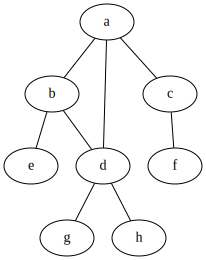

In [28]:
## plot the UDG corresponding to the Bayes net:
dot = Graph()
dot.node('A', 'a')
dot.node('B', 'b')
dot.node('C', 'c')
dot.node('D', 'd')
dot.node('E', 'e')
dot.node('F', 'f')
dot.node('G', 'g')
dot.node('H', 'h')
dot.edges(['AB', 'AC', 'AD', 'BD', 'BE', 'CF', 'DG', 'DH'])
dot

And then the joint probability distribution should be very simple to come up with:

$$
p(X) = \frac{1}{Z} \psi_{a,b,d} (a, b, d) \psi_{a, c}(a, c) \psi_{c, f}(c, f) \psi_{b, e}(b, e) \psi_{d, g}(d, g) \psi_{d, h}(d, h)
$$

where $Z$ is a normalizing constant defined as:

$$
Z = \sum_{X \in \{ a, b, ..., h\}} \psi_{a,b,d} (a, b, d) \psi_{a, c}(a, c) \psi_{c, f}(c, f) \psi_{b, e}(b, e) \psi_{d, g}(d, g) \psi_{d, h}(d, h)
$$

## 2.2 Now specify the Bayes net as a factor graph.  Again write the expression for the joint probability, but using factor functions.

We have two possible ways to draw the factor graph: we can either have the factor graph from the UDG of our Bayes net, or directly from the Bayes net. Since the latter one preserve more information regarding the marginal independence of the nodes in the graph, we shall go with that way. 

First of all let's have the joint distribution of the original Bayes net as below:

$$
p(X) = p(f|c)p(c|a)p(g|d)p(d|a, b)p(h|d)p(e|b)p(a)p(b)
$$
And then we shall draw the factor graph according to the distribution:

![factor graph p2.2](Images/p22.jpg)

Sorry for the sketchy handwriting, I could not use `graphviz` this time since there were some compatibility problems on my pc to have different shapes for the nodes.

And the factor function would just be:

$$
p(X) = f_1(f, c) f_2(c, a) f_3(g, d) f_4(d, a, b) f_5(h, d) f_6(e, b) f_7(b) f_8(a)
$$

## 2.3 Express the following Bayes net (from the sprinkler example) in two different factor graphs.  For each network, write the factors as a function of the conditional probabilties and specify the joint probability.

![p2.3 image](Images/p23.png)

In order to get two different factor graphs, we can first moralize the Bayes net to have an UDG. And then, we may have two graphs with one corresponding to the Bayes net directly, and another corresponding to the UDG we have. Let's first take a look at the factor graph deriving from the UDG of the Bayes net.

### From UDG to factor graph

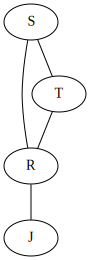

In [29]:
p23 = Graph()
p23.node('S', 'S')
p23.node('R', 'R')
p23.node('T', 'T')
p23.node('J', 'J')
p23.edges(['SR', 'ST', 'TR', 'RJ'])
p23

Then the factor graph of this is rather straightforward, which basically comes from the joint probability of the MRF as below:
$$
p(X) = \psi_{S, T, R}(S, T, R) \psi_{R, J}(R, J)
$$

And this tells us the factor graph as well as its joint probability:

![factor graph from UDG](Images/p23a.jpg)

$$ 
p(X) = f_1(S, T, R) f_2(R, J)
$$

Where the factors can be defined as:

$$
f_1 = \psi_{S, T, R}(S, T, R) = p(T|S,R)p(S)p(R), \space f_2 = \psi_{R, J}(R, J) = p(J|R)p(R)
$$

### From Bayes net to factor graph

As in the previous part, we need to first come up with the joint probability of the Bayes net in order to setup the factor graph. The joint distribution coming from the Bayes net can be expressed as below:

$$
p(X) = p(T|S,R)p(J|R)p(S)p(R)
$$

From the equation above, we may then derive the factor graph along with its joint probability equation.

![bayes factor graph](Images/p23b.jpg)

$$
p(X) = f_1(S,T,R)f_2(R,J)f_3(S)f_4(R)
$$

Where the factors can be defined as:

$$
f_1 = p(T|S,R), \space f_2 = p(J|R), \space f_3 = p(S), \space f_4 = p(R)
$$

# Exercise 3. The Sum Product Algorithm

Consider the following factor graph:

![problem 3 factor graph](Images/p3.png)

## 3.1 Apply the sum-product algorithm to compute the all messages when none of the variables are known.

In order to apply the sum-product algorithm to compute all messages of this factor graph, let's set node `a` to be the root  node, and node `b` and `d` will thus become the leaf nodes. Let's first start with the direction from leaf nodes to the root node.

leaves $\rightarrow$ root:

$
\mu_{d \rightarrow f_2}(d) = 1
$

$
\mu_{f_2 \rightarrow c}(d) = \sum_d f_2(d, c) 
$

$
\mu_{c \rightarrow f_1}(c) = \mu_{f_2 \rightarrow c}(d)
$

$
\mu_{b \rightarrow f_1}(b) = 1
$

$
\mu_{f_1 \rightarrow a}(b, c) = \sum_{b, c} f_1(b, c) \mu_{b \rightarrow f_1}(b) \mu_{c \rightarrow f_1}(c)
$

Then we shall go in the direction from root node to leaf nodes.

root $\rightarrow$ leaves: 

$
\mu_{a \rightarrow f_1}(a) = 1
$

$
\mu_{f_1 \rightarrow c}(a, b) = \sum_{a, b} f_1(a, b, c) \mu_{b \rightarrow f_1}(b) \mu_{a \rightarrow f_1}(a)
$

$
\mu_{c \rightarrow f_2}(c) = \mu_{f_1 \rightarrow c}(a, b)
$

$
\mu_{f_2 \rightarrow d}(c) = \sum_c f_2(c, d) \mu_{c \rightarrow f_2}(c)
$

## 3.2 Compute the marginal probability $p(c)$, expressing it in terms of the messages you derived in the previous question.

According to expression `8.63` from Bishop, the marginal probability of $x$ can be expressed as
$$
p(x) = \prod_{s \in ne(x)} [\sum_{X_s} F_s(x, X_s)]
$$
$$
= \prod_{s \in ne(x)} \mu_{f_s \rightarrow x} (x) 
$$

Therefore, the expression of marginal probability $p(c)$ would be
$$
p(c) = \mu_{f_2 \rightarrow c}(d) \mu_{f_1 \rightarrow c}(a, b)
$$

## 3.3 Verify that the marginal is the correct expression substituting in the message definitions.

From part 3.1 above, we already know that:

$
\mu_{f_2 \rightarrow c}(d) = \sum_d f_2(d, c) 
$

$
\mu_{f_1 \rightarrow c}(a, b) = \sum_{a, b} f_1(a, b, c) \mu_{b \rightarrow f_1}(b) \mu_{a \rightarrow f_1}(a)
$

Therefore, by substituting the message definitions above, the marginal will finally become:

$$
p(c) = [\sum_{a, b} f_1(a, b, c)] \mu_{b \rightarrow f_1}(b) \mu_{a \rightarrow f_1}(a) [\sum_d f_2(d, c)] 
$$
$$
= [\sum_{a, b} f_1(a, b, c)] [\sum_d f_2(d, c)]
$$
$$
= \sum_a \sum_b \sum_d f_1(a, b, c) f_2(d, c)
$$
where $f_1(a, b, c) f_2(d, c)$ is the factor function of the factor graph above, and the final expression we get is just the marginal expression derived from that equation. 

Therefore the marginal we get is the correct expression.

---

Now consider adding a loop to the graph.

![factor graph with loop](Images/p3loop.png)

## 3.4 Explore the consequences of applying the sum-product algorithm to this graph. Can the algorithm still be applied?

Let's come to the conclusion at first: NO, the algorithm CANNOT be applied in this case. The general idea of this is that by having a loop, the final experssion for marginal probability having the message definitions substituded will also contain a loop. Now we shall take a quick look at the expression of our marginal on `c`, as it might be quite a good example to demonstrate this. 

First of all, let's take a look at all the messages in the graph given node `a` is the root:

leaf $\rightarrow$ root:

$
\mu_{d \rightarrow f_2}(d) = 1
$

$
\mu_{f_2 \rightarrow b}(c, d) = \sum_{c, d} f_2(b, c, d) \mu_{c \rightarrow f_2}(c) \mu_{d \rightarrow f_2}(d)
$

$
\mu_{f_2 \rightarrow c}(b, d) = \sum_{b, d} f_2(b, c, d) \mu_{b \rightarrow f_2}(b) \mu_{d \rightarrow f_2}(d)
$

$
\mu_{b \rightarrow f_1}(b) = \mu_{f_2 \rightarrow b}(c, d)
$

$
\mu_{c \rightarrow f_1}(c) = \mu_{f_2 \rightarrow c}(b, d)
$

$
\mu_{f_1 \rightarrow a}(b, c) = \sum_{b, c} f_1(a, b, c) \mu_{b \rightarrow f_1}(b) \mu_{c \rightarrow f_1}(c)
$

root $\rightarrow$ leaf:

$
\mu_{a \rightarrow f_1}(a) = 1
$

$
\mu_{f_1 \rightarrow b}(a, c) = \sum_{a, c} f_1(a, b, c) \mu_{c \rightarrow f_1}(c) \mu_{a \rightarrow f_1}(a)
$

$
\mu_{f_1 \rightarrow c}(a, b) = \sum_{a, b} f_1(a, b, c) \mu_{b \rightarrow f_1}(b) \mu_{a \rightarrow f_1}(a)
$

$
\mu_{b \rightarrow f_2}(b) = \mu_{f_1 \rightarrow b}(a, c)
$

$
\mu_{c \rightarrow f_2}(c) = \mu_{f_1 \rightarrow c}(a, b)
$

$
\mu_{f_2 \rightarrow d}(b, c) = \sum_{b, c} f_2(b, c, d) \mu_{b \rightarrow f_2}(b) \mu_{c \rightarrow f_2}(c)
$



Then by using the sum-product algorithm, the mariginal probability of `c`, $p(c)$ should be:

$$
p(c) = \mu_{f_2 \rightarrow c}(b, d) \mu_{f_1 \rightarrow c}(a, b)
$$

$$
= [\sum_{b, d} f_2(b, c, d)] \mu_{b \rightarrow f_2}(b) \mu_{d \rightarrow f_2}(d) [\sum_{a, b} f_1(a, b, c)] \mu_{b \rightarrow f_1}(b) \mu_{a \rightarrow f_1}(a)
$$

$$
= [\sum_{b, d} f_2(b, c, d)] \mu_{f_1 \rightarrow b}(a, c) [\sum_{a, b} f_1(a, b, c)] \mu_{f_2 \rightarrow b}(c, d) 
$$

$$
= [\sum_{b, d} f_2(b, c, d)] [\sum_{a, c} f_1(a, b, c)] \mu_{c \rightarrow f_1}(c) \mu_{a \rightarrow f_1}(a) [\sum_{a, b} f_1(a, b, c)] [\sum_{c, d} f_2(b, c, d)] \mu_{c \rightarrow f_2}(c) \mu_{d \rightarrow f_2}(d)
$$

Whereas 

$
\mu_{c \rightarrow f_2}(c) = \mu_{f_1 \rightarrow c}(a, b)
$,

and

$
\mu_{c \rightarrow f_1}(c) = \mu_{f_2 \rightarrow c}(b, d)
$

which indicates we have a loop here. Therefore the equation can not be solved, and thus the algorithm cannot be applied.

---

# Exploration

## Introduction

So in Excercise 1, we did some practices on the denoising of binary images as well as greyscale images with MRF as introduced in `Chapter 8` of Bishop. By the end of `8.3.3`, the textbook also mentions how belief propogation with sum-product and max-product algorithm can be a more effective algorithm for finding high probability solutions. Trying to improve the denoised image quality from my part 1.5, I did some researches on how the two algorithms can be applied to greyscale image denoising. However, given limited knowledge and resources about belief propogation with continous variables, I finally decided to make my exploration focused on binary images. 

In my exploration, I will go through the important steps of how to setup a denoising algorithm based on belief propogation as below:

1. Have a UDG as a graphical model for image processing.  
2. Setup a factorial graph corresponding to the graphical model above. Define the factors as well as the variables.  
3. Based on the factorial graph, setup the joint probability distribution $p(X)$.  
4. Define the belief propogation based on the sum-product and max-product algorithm as the iterative update function of our algorithm.  
5. Describe how to apply the update function to achieve denoising on binary images.  

### UDG as a graphical model for image processing

As in exercise 1 above, we still make the assumption that the causes of noises are independent to each other. Therefore, a simple undirected graphical model for image denoising should just look like Figure 8.31 from Bishop as provided below:

![udg for image denoising](Images/p4udg.png)

### Factor graph

Given the UDG above, it should be pretty simple to construct a corresponding factor graph as below:

![factor graph for image denoising](Images/p4factor.png)

In this case, we have two factors as following: $f_i(x_i, y_i)$ and $f_{i, j}(x_i, x_j)$. 

$f_i(x_i, y_i)$ describes the factor between the pixel and its neighbouring pixels, whereas $f_{i, j}(x_i, x_j)$ describes the factor between the pixel and its corresponded observable node. Given a binary image with pixel value $\in [0, 1]$, we shall define the factors as a $2 \times 2$ matrix as below: 

$$f_i(x_i, y_i) = \begin{bmatrix} 1 & 1 - \eta \\ 1 - \eta & 1 \end{bmatrix} $$

$$f_{i, j}(x_i, x_j) = \begin{bmatrix} 1 & 1 - \beta \\ 1 - \beta & 1 \end{bmatrix} $$

Where $\eta$ and $\beta$ represents a positive floating constant ranging from $[0, 1]$. We take the two constants as parameters to define our function. An alternative way to express the above factors can be achieve through setting up potential functions, which, similarly, will just be: 

$$\psi_i(x_i, y_i) = \begin{bmatrix} 1 & 1 - \eta \\ 1 - \eta & 1 \end{bmatrix} $$

$$\psi_{i, j}(x_i, x_j) = \begin{bmatrix} 1 & 1 - \beta \\ 1 - \beta & 1 \end{bmatrix} $$

### Joint probability 

Given the factor graph above, let's briefly take a look  at what the joint probability of our image denoising model should look like: 

$$
p(X) = [\prod_{i,j} \psi_{i,j}(x_i, x_j)] [\prod_i \psi(x_i, y_i)], \space j \in nbr(i)
$$

Then without applying the belief propogation algorithm, a "raw" marginal probability $p(x_i)$ on one pixel `xi` would become

$$
p(x_i) = \sum_{i, j \in nbr(i)} [[\prod_{i,j} \psi_{i,j}(x_i, x_j)] [\prod_i \psi(x_i, y_i)]]
$$

### Update function with belief propogation

As we've obtained the marginal probability expression on one variable, a more efficient way in the form of message transmitting between neighbouring variables can be done as suggested in exercise 3 with belief propogation. For simplicity, the message definitions will be using potential functions instead of the factors since all factors are pairwise and we don't need to worry above trinity or above. 

For a pixel variable $x_i$, and all its neigbours $x_j$, along with the observation on the respective pixel $y_i$, the marginal probability of $x_i$ with belief propogation is just:

$$
p(x_i) = \mu_{y_i \rightarrow x_i}(y_i) [\prod_{i, j \in nbr(i)} \mu_{x_j \rightarrow x_i} (x_j)]
$$

where the definition of messages passing to the variable is 

$
\mu_{y_i \rightarrow x_i}(y_i) = \sum_{y_i} \psi_i (x_i, y_i) = \psi_i (x_i, y_i)
$

$
\mu_{x_j \rightarrow x_i} (x_j) = \sum_{x_j} \psi_{i, j}(x_i, x_j)
$

This allows us to separate the messages sent from different variables, and ultimately have a more efficient way to calculate the marginal probability. The equation above will become the update function for each variable during each iteration. 


### Update function in use

Previously in Exercise 1 we used the energy function along with its difference as a criterion of the quality of a variable. With belief propogation, we can do something quite the same. 

- First of all, we shall pick a random pixel $x_i$ from the image and then check its opposite color given that we are inspecting a binary image.  
- We compare the marginal probability of current pixel value as well as the opposite one by using the potential function above, and determine if the new value promotes a higher probability.  
- If the new value has a higher probability, we shall take the result, and pass the message corresponding to it, $\mu_{x_i \rightarrow x_j} (x_i)$, to all its neighbours $x_j$ with the updating function we previously define. To completely update all relevant pixels, we need to call the updating function recursively on the neighbours until the entire image is updated.  
- If the marginal probability is not higher than the original one, we can still accept the result with a probability in the same mannar as we did it with simulated annealing. If the result is accepted, we udpate the whole image as in the previous condition.  

  To avoid writing a whole chapter, I will only implement the marginal probability along with the potential functions as below. The complete integration will not be covered in my exploration section as I'm still trying to figure out how to implement the updating function.  
  My major concern here is how to avoid synchonization without using any lock/semaphore since the expansion of th updating process might overlap, and I'm not sure how to handle such situation. Feel free to give me helpful comment on how to get it done, I'd love to make this an individual project of mine once this problem is solved. 

In [30]:
## retrieving a message according to the given parameters
## v: indicating which potential function we are applying here
## v = 0: comparing to original observation; v = 1: comparing to neighbours
## we assume the nbr is a list of indices of k's neighbours
def get_msg (pixels, obsv, nbr, k, beta, eta, v):
    if v == 0: 
        potential = [[1, 1 - eta][1 - eta, 1]]
        return potential[pixels[k], obsv[k]]
    else:
        potential = [[1, 1 - beta][1 - beta, 1]]
        output = 0
        for j in nbr:
            output += potential[pixels[k], pixels[j]]
        return output
    
def marginal_prob (pixels, nbr, k, yk, beta, eta):
    ## initialize with muykxk
    output = get_msg(pixels, obsv, nbr, k, beta, eta, 0)
    for j in nbr:
        ## muxjxk, again we assume get_nbr retrieves a list of indices of j's neighbours
        msg = get_msg(pixels, obsv, get_nbr(j), j, beta, eta, 1)
        output *= msg
    return output


End of exploration part. 

---